In [86]:
import numpy as np
import geopandas
import pandas as pd
from sklearn import cluster
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm
from tqdm import tqdm
import sklearn
from shapely.geometry import Polygon
from shapely import wkt
import re
import geopandas
from shapely import wkt
import random

In [87]:
county_conn_df = pd.read_pickle(r'C:\Users\mgm24\Documents\datasets\county_conn.pkl') 
sci_dist_df = pd.read_pickle(r'C:\Users\mgm24\Documents\datasets\sci_dist.pkl')
geo_dist = np.load(r'C:\Users\mgm24\Documents\datasets\geo_dist.npy')
sci_dist_df.head(5)

fr_loc,1001,1003,1005,1007,1009,1011,1013,1015,1017,1019,...,56027,56029,56031,56033,56035,56037,56039,56041,56043,56045
user_loc,,,,,,,,,,,,,,,,,,,,,
1001,1.117710e-07,9.804210e-06,7.443744e-06,3.927421e-06,1.488184e-05,2.330883e-06,0.000001,0.000014,0.000009,0.000028,...,0.000573,0.000597,0.000418,0.000810,0.000730,0.000561,0.000344,0.000731,0.001028,0.001453
1003,9.804210e-06,3.172975e-07,1.997443e-05,1.228879e-05,1.490024e-05,3.052969e-05,0.000006,0.000016,0.000025,0.000026,...,0.000805,0.000371,0.000298,0.000522,0.000279,0.000634,0.000158,0.000521,0.000717,0.000442
1005,7.443744e-06,1.997443e-05,2.212110e-08,3.133912e-05,5.388512e-05,1.598885e-07,0.000004,0.000018,0.000006,0.000060,...,0.000738,0.000713,0.001277,0.001645,0.001242,0.001695,0.000350,0.002358,0.001427,0.001580
1007,3.927421e-06,1.228879e-05,3.133912e-05,2.434424e-08,4.175470e-06,1.999440e-05,0.000008,0.000012,0.000028,0.000023,...,0.002273,0.000667,0.000647,0.001488,0.000774,0.001898,0.001058,0.001502,0.001391,0.001019
1009,1.488184e-05,1.490024e-05,5.388512e-05,4.175470e-06,7.533211e-08,7.212926e-05,0.000034,0.000005,0.000038,0.000006,...,0.002457,0.000709,0.000665,0.000320,0.001105,0.000487,0.000668,0.001079,0.000875,0.000513


In [88]:
# vectorize pairwise distances
sci_dist_df = pd.melt(sci_dist_df, ignore_index=False) 
sci_dist = np.asarray(sci_dist_df['value'])
geo_dist = geo_dist.reshape((geo_dist.shape[0]**2,1)) #this reorganizes elements in the same way as pd.melt
sci_dist_df.head(5)

,fr_loc,value
user_loc,,
1001,1001,1.117710e-07
1003,1001,9.804210e-06
1005,1001,7.443744e-06
1007,1001,3.927421e-06
1009,1001,1.488184e-05


In [89]:
# Convert sci_dist into a connectedness measure
sci_dist_df['geo_dist'] = geo_dist
sci_dist_df['SDI'] = sci_dist_df['value']
sci_dist_df['SCI'] = 1/sci_dist_df['value']
# sci = 1/sci_dist

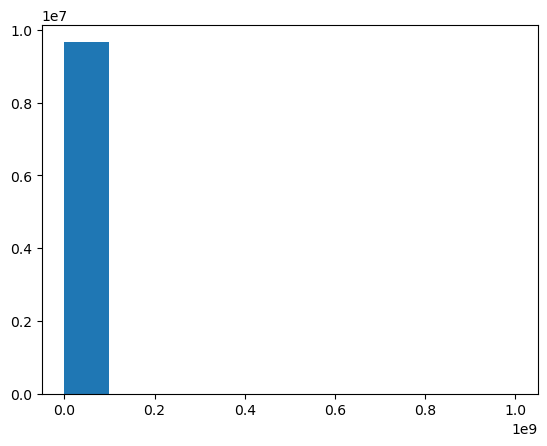

In [90]:
_ = plt.hist(sci_dist_df['SCI'])

Remove outlier points

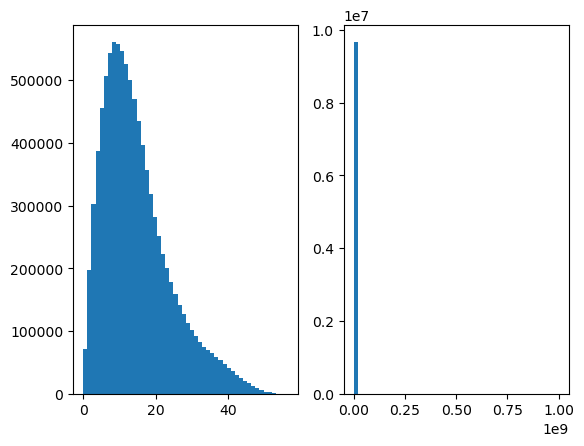

In [91]:
plt.subplot(1,2,1)
_ = plt.hist(sci_dist_df['geo_dist'], bins=50)
plt.subplot(1,2,2)
_ = plt.hist(sci_dist_df['SCI'], bins=50)

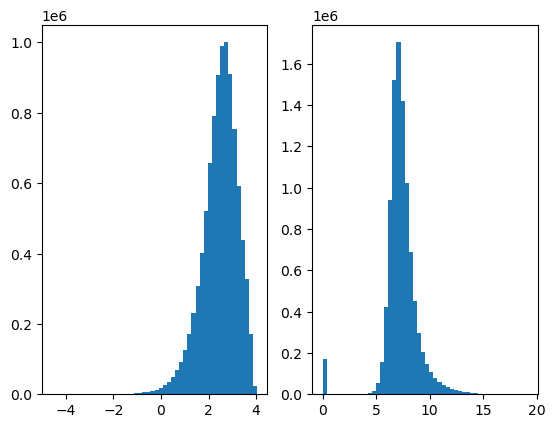

In [92]:
# Log scale
sci_dist_df = sci_dist_df[sci_dist_df['geo_dist']>0]
sci_dist_df['log_geo_dist'] = np.log(sci_dist_df['geo_dist'])
sci_dist_df['log_SCI'] = np.log(sci_dist_df['SCI'])
plt.subplot(1,2,1)
_ = plt.hist(sci_dist_df['log_geo_dist'], bins=50) # +.001 to prevent 0 errors
plt.subplot(1,2,2)
_ = plt.hist(sci_dist_df['log_SCI'], bins=50)

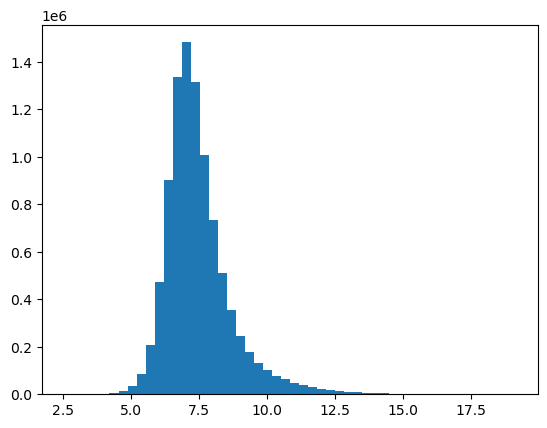

In [93]:
# Remove outliers
sci_dist_df = sci_dist_df[sci_dist_df['log_SCI']>.1]
_ = plt.hist(sci_dist_df['log_SCI'], bins=50)

In [94]:
# Only plot a subsample (too many points otherwise) (MAYBE DELETE)
# import random
# samples = random.sample(range(len(sci)), 1000)
# plt.scatter(np.log(geo_dist[samples]), np.log(sci[samples]))
# plt.xlabel('Geographical distance')
# plt.ylabel('Social distance')

Samples with a distance greater than 4.511534669127608: 8707544


Text(0, 0.5, 'Social connectedness')

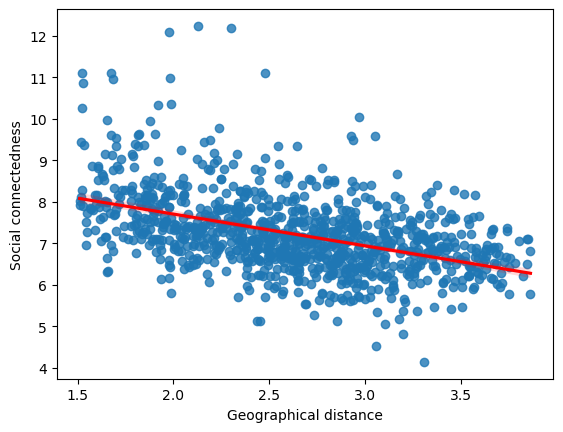

In [95]:
dist = np.percentile(sci_dist_df['geo_dist'], 10)
print('Samples with a distance greater than '+str(dist)+': '+ str(np.sum(geo_dist>dist)))
sci_dist_df = sci_dist_df[sci_dist_df['geo_dist']>dist]
samples = random.sample(range(sci_dist_df.shape[0]), 1000)
samples = random.sample(range(sci_dist_df.shape[0]), 1000)
sns.regplot(x=sci_dist_df.iloc[samples]['log_geo_dist'], y=sci_dist_df.iloc[samples]['log_SCI'],
           line_kws={"color": "red"})
# plt.scatter(np.log(geo_far[samples]), np.log(sci_far[samples]))
plt.xlabel('Geographical distance')
plt.ylabel('Social connectedness')

Let's look at the relationship between geographical distance and social distance. Since we're only interested in when social distance is unexpectadly small when the counties are geographically distant, we'll remove the counties where the geographical distance is small.

TODO change: How effective is this model? Let's plot the diagnostic plots for this regression. Looking at the residual plots can also tell us about the outliers we're interested in.

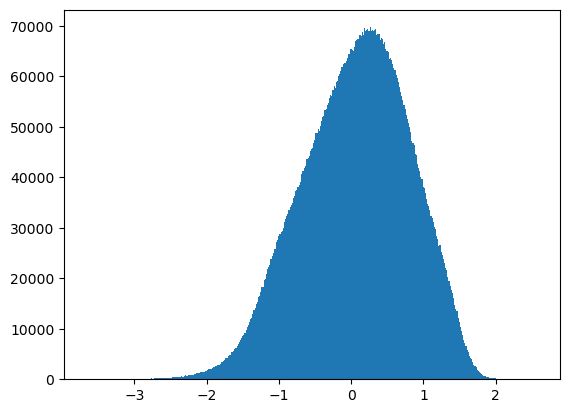

In [96]:
results = sm.OLS(sci_dist_df['log_geo_dist'], sci_dist_df['log_SCI']).fit()
residuals = results.resid
_ = plt.hist(residuals, bins=400)
sci_dist_df['resid'] = residuals
# plt.xlim(-.003, .006)

The residuals have a heavy right tail -- meaning there is a lot of points where the actual social distance is much more than the predicted social distance -- the data we're intersted in!

In [97]:
sci_dist_df

,fr_loc,value,geo_dist,SDI,SCI,log_geo_dist,log_SCI,resid
user_loc,,,,,,,,
4001,1001,0.001346,23.024480,0.001346,743.0,3.136558,6.610696,0.801177
4003,1001,0.000357,23.117718,0.000357,2799.0,3.140599,7.937017,0.336665
4005,1001,0.000938,25.344027,0.000938,1066.0,3.232543,6.971669,0.769640
4007,1001,0.000875,24.202042,0.000875,1143.0,3.186437,7.041412,0.698896
4009,1001,0.001089,23.248064,0.001089,918.0,3.146222,6.822197,0.736123
...,...,...,...,...,...,...,...,...
56029,56045,0.000004,5.066707,0.000004,278568.0,1.622691,12.537417,-2.806441
56035,56045,0.000004,5.453757,0.000004,250626.0,1.696305,12.431717,-2.695487
56037,56045,0.000007,4.832054,0.000007,152425.0,1.575272,11.934428,-2.640841


Let's look at the results. We're interested in counties with a much smaller social distance than expected, or where the residual (x - predict(x)) is negative.

In [98]:
county_data = pd.read_csv('G:\My Drive\ds_projects\cdcs-social-vulnerability-index-svi-2016-overall-svi-county-level.csv')
county_data = county_data.set_index('fips')
county_data_select = county_data.loc[:, ['county', 'state']]
sci_dist_df = sci_dist_df.join(county_data_select, how='left')
sci_dist_df = sci_dist_df.rename(columns={'county':'user_county', 'state':'user_state'})
sci_dist_df['user_loc'] = sci_dist_df.index
sci_dist_df = sci_dist_df.set_index('fr_loc')
sci_dist_df = sci_dist_df.join(county_data_select, how='left')
sci_dist_df = sci_dist_df.rename(columns={'county':'fr_county', 'state':'fr_state'})
sci_dist_df['fr_loc'] = sci_dist_df.index
sci_dist_df.sort_values('resid', ascending=True).head(10)

,value,geo_dist,SDI,SCI,log_geo_dist,log_SCI,resid,user_county,user_state,user_loc,fr_county,fr_state,fr_loc
30033,3.481489e-07,4.914897,3.481489e-07,2872334.0,1.592271,14.870635,-3.661125,Niobrara,WYOMING,56027,Garfield,MONTANA,30033
56027,3.481489e-07,4.914897,3.481489e-07,2872334.0,1.592271,14.870635,-3.661125,Garfield,MONTANA,30033,Niobrara,WYOMING,56027
8057,2.927426e-07,5.358683,2.927426e-07,3415970.0,1.678718,15.043972,-3.635912,McPherson,NEBRASKA,31117,Jackson,COLORADO,8057
31117,2.927426e-07,5.358683,2.927426e-07,3415970.0,1.678718,15.043972,-3.635912,Jackson,COLORADO,8057,McPherson,NEBRASKA,31117
30019,5.708085e-07,4.565297,5.708085e-07,1751901.0,1.518483,14.376212,-3.560246,Hill,MONTANA,30041,Daniels,MONTANA,30019
30041,5.708085e-07,4.565297,5.708085e-07,1751901.0,1.518483,14.376212,-3.560246,Daniels,MONTANA,30019,Hill,MONTANA,30041
46063,5.689829e-07,4.608076,5.689829e-07,1757522.0,1.527811,14.379415,-3.552050,Hand,SOUTH DAKOTA,46059,Harding,SOUTH DAKOTA,46063
46059,5.689829e-07,4.608076,5.689829e-07,1757522.0,1.527811,14.379415,-3.552050,Harding,SOUTH DAKOTA,46063,Hand,SOUTH DAKOTA,46059
31009,4.360078e-07,5.082756,4.360078e-07,2293537.0,1.625854,14.645606,-3.548045,Harding,SOUTH DAKOTA,46063,Blaine,NEBRASKA,31009
46063,4.360078e-07,5.082756,4.360078e-07,2293537.0,1.625854,14.645606,-3.548045,Blaine,NEBRASKA,31009,Harding,SOUTH DAKOTA,46063


In [99]:
county_data = pd.read_csv('G:\My Drive\ds_projects\cdcs-social-vulnerability-index-svi-2016-overall-svi-county-level.csv')
county_data['geometry'] = county_data['geometry'].apply(wkt.loads)
county_data = geopandas.GeoDataFrame(county_data)
county_data = county_data.set_index('fips')

geometry_data = county_data.loc[:, ['geometry']]
sci_dist_df = sci_dist_df.set_index('fr_loc')
sci_dist_df = sci_dist_df.join(geometry_data, how='left')
sci_dist_df['fr_loc'] = sci_dist_df.index
sci_dist_df = geopandas.GeoDataFrame(sci_dist_df)

In [100]:
# sci_dist_df['SCI'] = 1/sci_dist_df['value'] 
## TODO: Should really create the SCI at the start, and work with it from the start. But last time I tried that, the results went to crap. Maybe my own error, maybe from cleaning it up
## rather than just using its raw value.

In [101]:
def plot_suprising_counties(sci_dist_df, user_loc, resid, n_counties=10):
    tc_df = sci_dist_df[sci_dist_df['user_loc']==user_loc]
    fig, ax = plt.subplots(figsize=(11,10))
    tc_df.plot('SCI', ax=ax)
    tc_df.sort_values(resid, ascending=False).head(n_counties).boundary.plot(color='red', ax=ax)

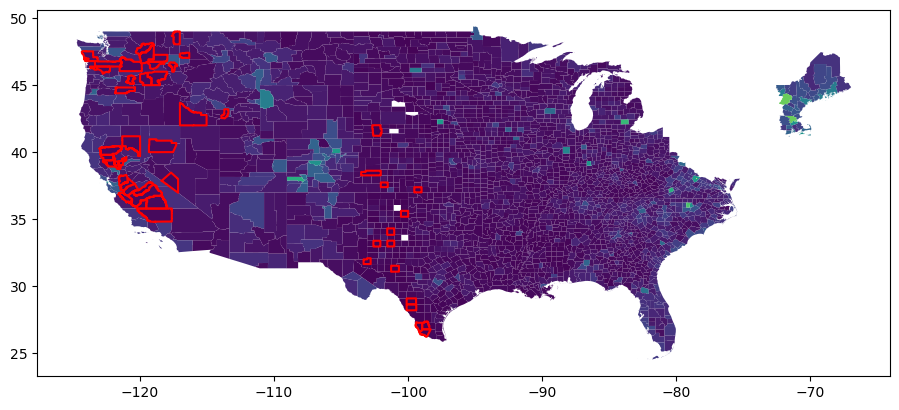

In [102]:
plot_suprising_counties(sci_dist_df, 36109, 'resid', 50)

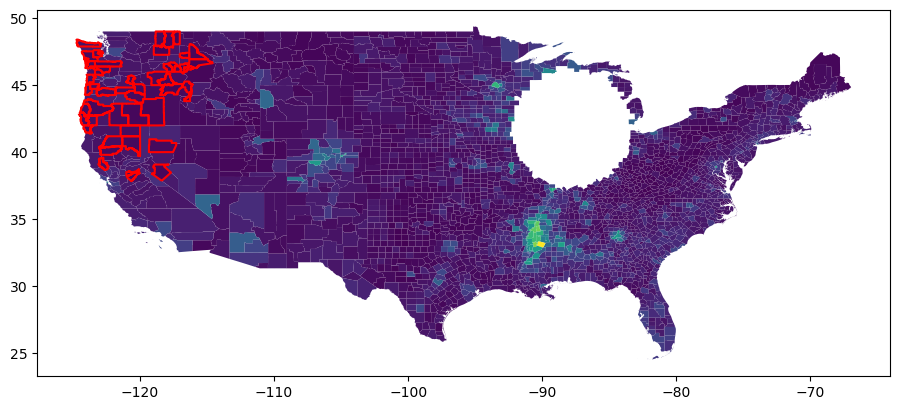

In [103]:
plot_suprising_counties(sci_dist_df, 17031, 'resid', 50)

This is problematic because of non linearities in the relationship.

In [104]:
density_info = pd.read_excel(r'C:\Users\mgm24\Documents\datasets\URAmericaMapCountyList.xlsx', header=3, index_col='CountyFIPS') #index_col='CountyFIPS'
density_info = density_info.loc[:, ['Density2016_SqMi', 'Population2016']]
# density_info = density_info.loc[:, 'Density2016_SqMi']
sci_dist_df = sci_dist_df.set_index('user_loc')
sci_dist_df = sci_dist_df.join(density_info, how='left')
sci_dist_df['user_loc'] = sci_dist_df.index
sci_dist_df = sci_dist_df.rename(columns={'Density2016_SqMi':'user_density', 'Population2016':'user_pop'})
sci_dist_df = sci_dist_df.set_index('fr_loc')
sci_dist_df = sci_dist_df.join(density_info, how='left')
sci_dist_df['fr_loc'] = sci_dist_df.index
sci_dist_df = sci_dist_df.rename(columns={'Density2016_SqMi':'fr_density', 'Population2016':'fr_pop'})

In [105]:
sci_dist_df['pairdensity_avg'] = (sci_dist_df['user_density'] + sci_dist_df['fr_density']) / 2

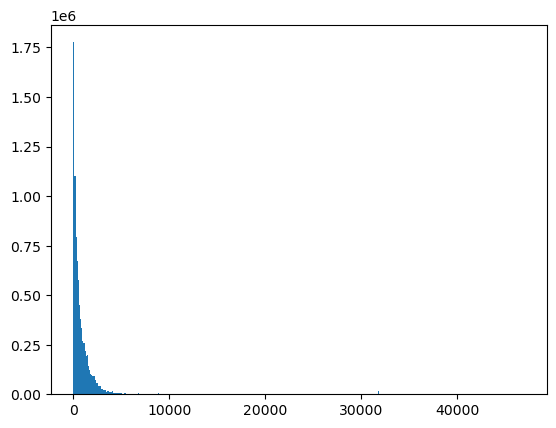

In [106]:
_ = plt.hist(sci_dist_df['pairdensity_avg'], bins=400)

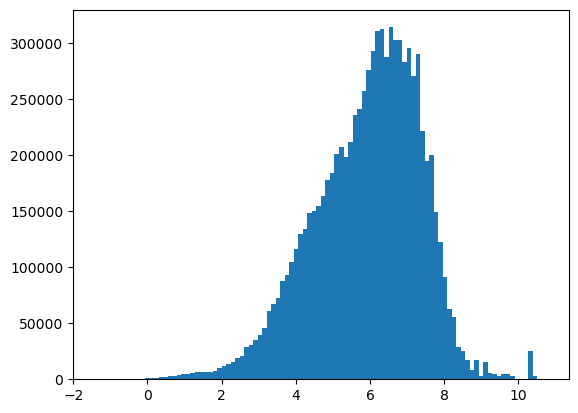

In [107]:
_ = plt.hist(np.log(sci_dist_df['pairdensity_avg']), bins=100)

<AxesSubplot:xlabel='log_pairdensity', ylabel='resid'>

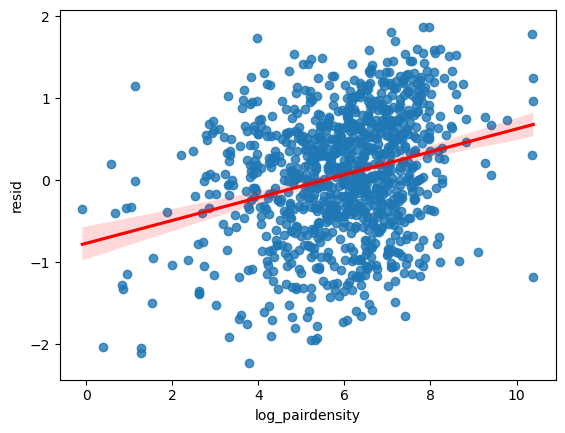

In [108]:
sci_dist_df['log_pairdensity'] = np.log(sci_dist_df['pairdensity_avg'])
samples = random.sample(range(sci_dist_df.shape[0]), 1000)
sns.regplot(data=sci_dist_df.iloc[samples], x='log_pairdensity', y='resid',
           line_kws={"color": "red"})
# plt.xlim(0, 25)

There is indeed a relationship between the residuals and the population density of the counties: as the population density of the counties increases, the residual increases as well. This means lower population density leads the regression to predict a lower social distance than actually observed. This makes sense, as in population sparse regions, friendships are likely farther apart.

Now, let's run a regression including both geographic distances and population density.

In [109]:
results = sm.OLS(sci_dist_df['SCI'], sci_dist_df[['log_geo_dist','log_pairdensity']]).fit()

sci_dist_df['geo_density_resid'] = results.resid

Now, the county pairings with unexpectadly high social connections are all very far apart, which is more of the kinds of pairs we're interested in.

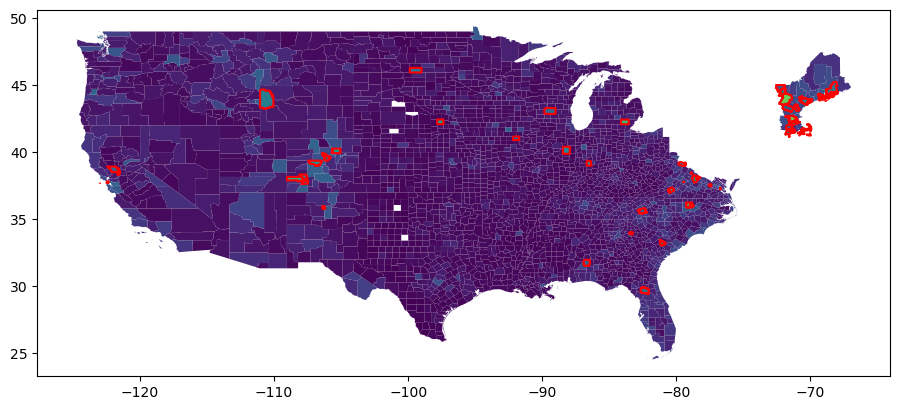

In [110]:
plot_suprising_counties(sci_dist_df, 36109, 'geo_density_resid', n_counties=50)

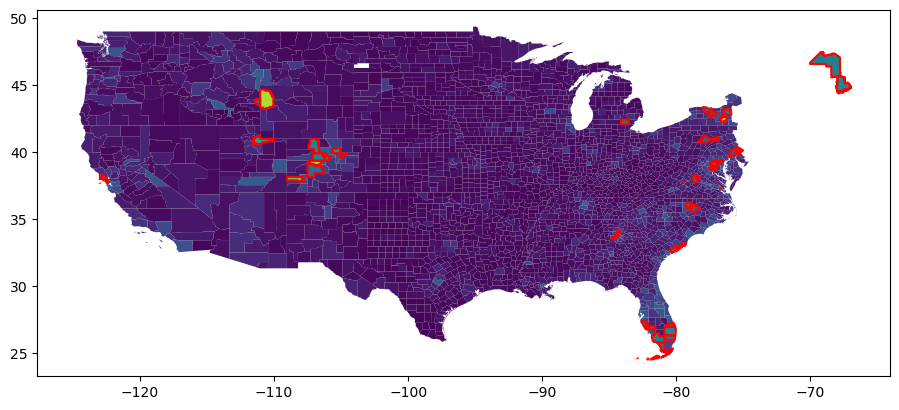

In [111]:
# Norfolk county?
plot_suprising_counties(sci_dist_df, 25021, 'geo_density_resid', n_counties=50)

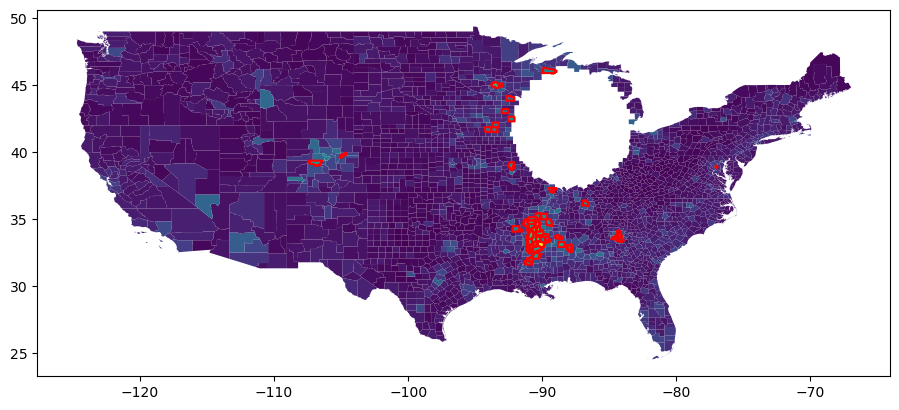

In [112]:
# cook county?
plot_suprising_counties(sci_dist_df, 17031, 'geo_density_resid', n_counties=50)

These results are cetainly a step forward. Still, they aren't perfect. The main problem in my opinion is the model really favors counties that are very far apart. Really, the relationship between social distance and geographical distance is likely nonlinear, such that after a certain geographical distance, social distances likely stop decreasing nearly as much. Let's try a regression capable of modeling these non-linearities: a K-nearest neighbors regression should do the trick.

In [113]:
n_neighbors = 100000
knn_model = sklearn.neighbors.KNeighborsRegressor(n_neighbors=50, weights='uniform')
# X = sci_dist_df[['log_geo_dist','log_pairdensity']]
X = sci_dist_df[['geo_dist']]
y = sci_dist_df['SCI']
results = knn_model.fit(X, y)

In [114]:
if n_neighbors < 20:
    predictions = knn_model.predict(X)
    residuals = y - predictions
    sci_dist_df['knn_resid'] = residuals
else:
    # predict in batches (to avoid memory error)
    batch_size = 1000
    batches = np.arange(0, sci_dist_df.shape[0], batch_size)
    batches = batches[:-1] #remove last batch
    sci_dist_df.reset_index(inplace=True, drop=True)
    sci_dist_df['knn_resid'] = np.nan
    for batch in tqdm(batches, total=len(batches)):
        Xx = X[batch:batch+batch_size]
        Yy = y[batch:batch+batch_size]
        predictions = knn_model.predict(Xx)
        sci_dist_df.loc[batch:batch+batch_size-1, 'knn_resid'] = np.asarray(Yy - predictions)

    Xx = X[batch+batch_size:]
    Yy = y[batch+batch_size:]
    predictions = knn_model.predict(Xx)
    sci_dist_df.loc[batch+batch_size:, 'knn_resid'] = np.asarray(Yy - predictions)

100%|██████████████████████████████████████████████████████████████████████████████| 8538/8538 [02:16<00:00, 62.68it/s]


In [115]:
sci_dist_df.sort_values('knn_resid', ascending=True).head(5)

,value,geo_dist,SDI,SCI,log_geo_dist,log_SCI,resid,user_county,user_state,fr_county,...,user_density,user_pop,user_loc,fr_density,fr_pop,fr_loc,pairdensity_avg,log_pairdensity,geo_density_resid,knn_resid
3985639,0.001931,5.358680,0.001931,518.0,1.678718,6.249975,-0.529230,Tunica,MISSISSIPPI,Bates,...,70.032239,10234,28143,120.989556,16417,29013,95.510898,4.559240,-1063.294572,-140405.88
3939750,0.001931,5.358680,0.001931,518.0,1.678718,6.249975,-0.529230,Bates,MISSOURI,Tunica,...,120.989556,16417,29013,70.032239,10234,28143,95.510898,4.559240,-1063.294572,-140405.88
7912134,0.000615,5.358742,0.000615,1625.0,1.678729,7.393263,-0.933112,Fulton,OHIO,Bristol City,...,362.726879,42514,39051,514.018343,16960,51520,438.372611,6.083069,-175.786664,-140162.00
5585420,0.000615,5.358742,0.000615,1625.0,1.678729,7.393263,-0.933112,Bristol City,VIRGINIA,Fulton,...,514.018343,16960,51520,362.726879,42514,39051,438.372611,6.083069,-175.786664,-140162.00
5715180,0.000907,5.358670,0.000907,1102.0,1.678716,7.004882,-0.795921,Patrick,VIRGINIA,Shelby,...,41.234001,17923,51141,934.450756,48623,39149,487.842378,6.189992,-714.179952,-139986.84


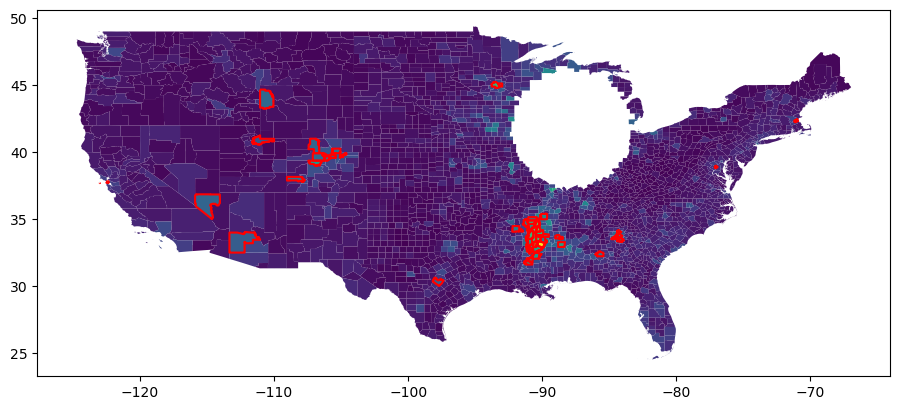

In [116]:
plot_suprising_counties(sci_dist_df, 17031, 'knn_resid', n_counties=50)

This misses the Mississipi river counties, probably because in the west, far apart counties still have lots of connections, meaning the model is not that surprised to see counties at this distance have lots of connections.

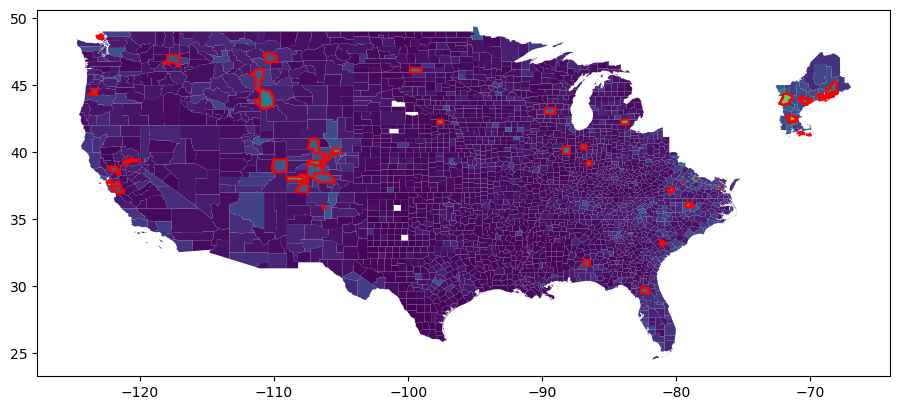

In [117]:
plot_suprising_counties(sci_dist_df, 36109, 'knn_resid', n_counties=50)

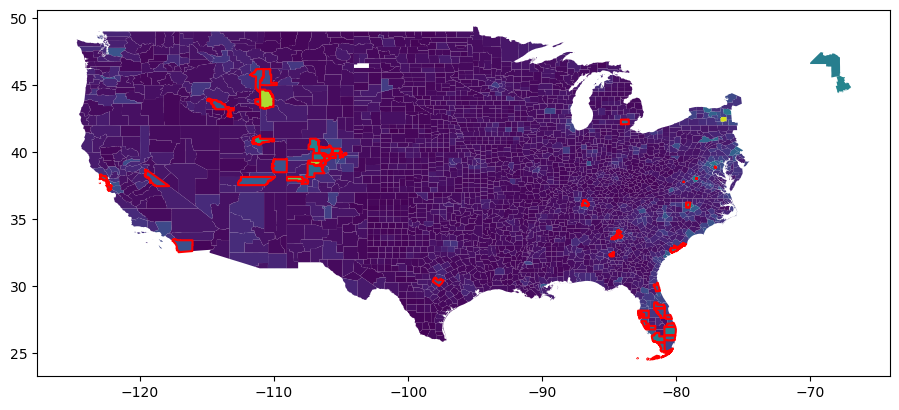

In [118]:
plot_suprising_counties(sci_dist_df, 25021, 'knn_resid', n_counties=50)

In [119]:
# Get x, y coords
county_data = pd.read_csv('G:\My Drive\ds_projects\cdcs-social-vulnerability-index-svi-2016-overall-svi-county-level.csv')
county_data['geometry'] = county_data['geometry'].apply(wkt.loads)
county_data = geopandas.GeoDataFrame(county_data)

# Convert r Polygon text to shapely polygon
for row_idx, row in county_data.iterrows():
    points = re.findall(r'-?\d+.\d+', row['geometry'].wkt)
    i = 0
    list_points = []
    while i < len(points):
        list_points.append((float(points[i]), float(points[i+1])))
        i+=2
    list_points

    county_shape = Polygon(list_points)
    county_center = county_shape.centroid
    center_points = re.findall(r'-?\d+.\d+', county_center.wkt)
    county_data.at[row_idx, 'center_long'] = float(center_points[0])
    county_data.at[row_idx, 'center_lat'] = float(center_points[1])

In [120]:
# Try including x, y coords in model
county_data = county_data.set_index('fips')
center_loc = county_data.loc[:, ['center_long', 'center_lat']]
sci_dist_df = sci_dist_df.set_index('user_loc')
sci_dist_df = sci_dist_df.join(center_loc, how='left')
sci_dist_df['user_loc'] = sci_dist_df.index
sci_dist_df = sci_dist_df.rename(columns={'center_long':'user_center_long', 'center_lat':'user_center_lat'})
sci_dist_df = sci_dist_df.set_index('fr_loc')
sci_dist_df = sci_dist_df.join(center_loc, how='left')
sci_dist_df['fr_loc'] = sci_dist_df.index
sci_dist_df = sci_dist_df.rename(columns={'center_long':'fr_center_long', 'center_lat':'fr_center_lat'})

In [121]:
n_neighbors = 10

knn_model = sklearn.neighbors.KNeighborsRegressor(n_neighbors=n_neighbors, weights='uniform')
X = sci_dist_df[['user_center_long','user_center_lat','fr_center_long','fr_center_lat']]
y = sci_dist_df['SCI']
results = knn_model.fit(X, y)

if n_neighbors < 25:
    predictions = knn_model.predict(X)
    residuals = y - predictions
    sci_dist_df['knn_xy_resid'] = residuals

else: #predict in batch to avoid memory error
    batch_size = 1000
    batches = np.arange(0, sci_dist_df.shape[0], batch_size)
    batches = batches[:-1] #remove last batch
    sci_dist_df.reset_index(inplace=True, drop=True)
    sci_dist_df['knn_resid'] = np.nan
    for batch in tqdm(batches, total=len(batches)):
        Xx = X[batch:batch+batch_size]
        Yy = y[batch:batch+batch_size]
        predictions = knn_model.predict(Xx)
        sci_dist_df.loc[batch:batch+batch_size-1, 'knn_xy_resid'] = np.asarray(Yy - predictions)

    Xx = X[batch+batch_size:]
    Yy = y[batch+batch_size:]
    predictions = knn_model.predict(Xx)
    sci_dist_df.loc[batch+batch_size:, 'knn_xy_resid'] = np.asarray(Yy - predictions)


C:\Users\mgm24\anaconda3\envs\DS_projects\lib\site-packages\geopandas\plotting.py:399: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


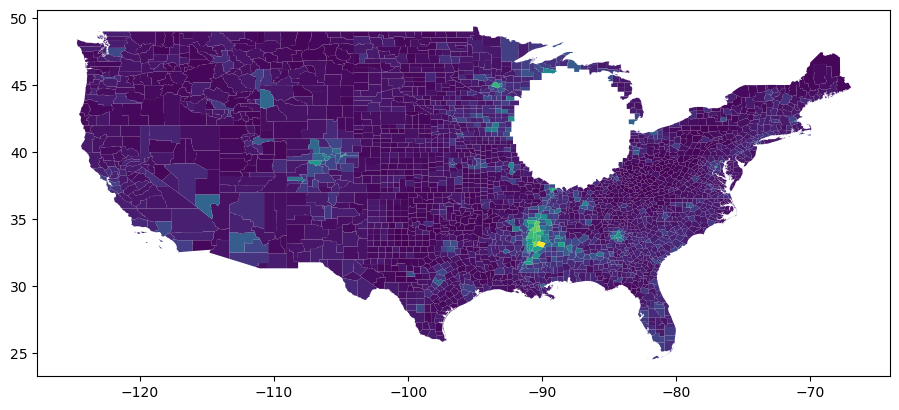

In [122]:
plot_suprising_counties(sci_dist_df, 17031, 'resid', n_counties=0)

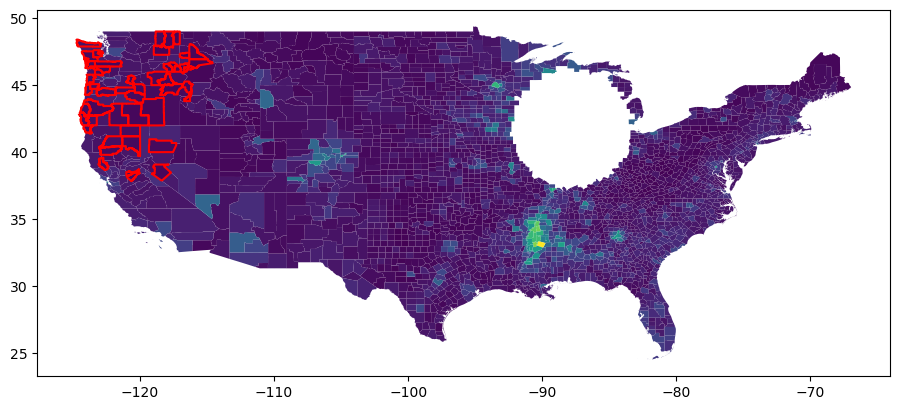

In [123]:
plot_suprising_counties(sci_dist_df, 17031, 'resid', n_counties=50)

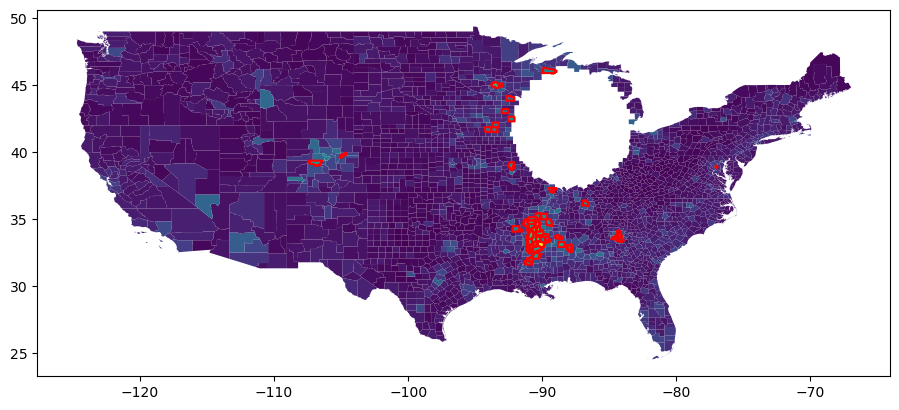

In [124]:
plot_suprising_counties(sci_dist_df, 17031, 'geo_density_resid', n_counties=50)

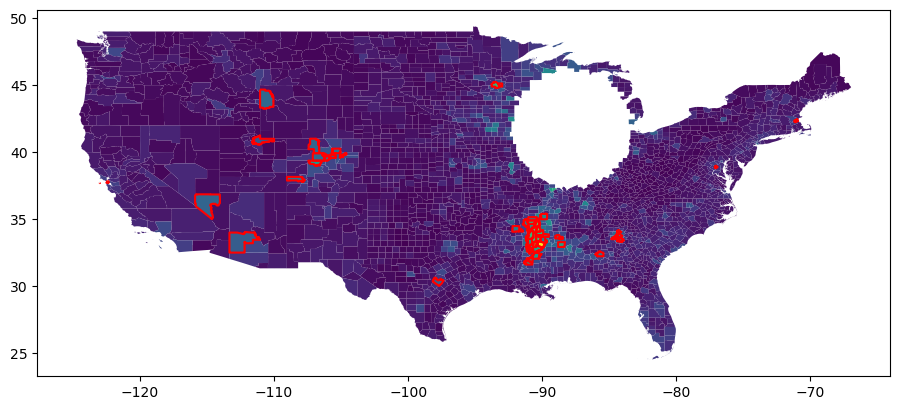

In [125]:
plot_suprising_counties(sci_dist_df, 17031, 'knn_resid', n_counties=50)

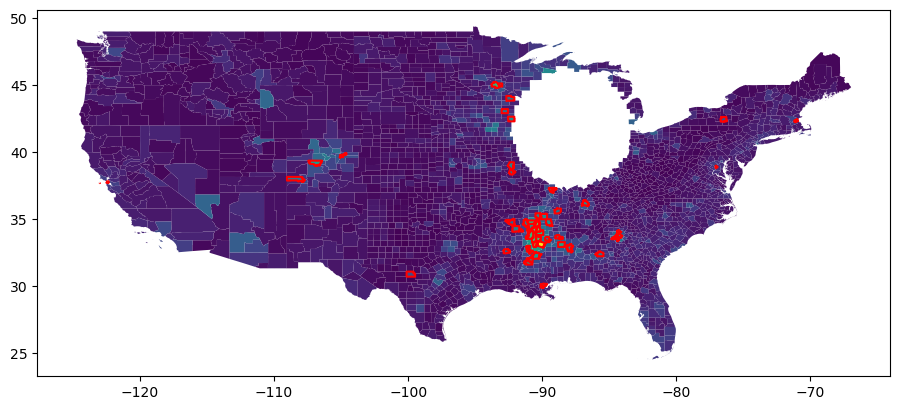

In [126]:
plot_suprising_counties(sci_dist_df, 17031, 'knn_xy_resid', n_counties=50)

In [152]:
# Filter on avg pop
dist = np.percentile(sci_dist_df['geo_dist'], 50)
geofar_df = sci_dist_df[sci_dist_df['geo_dist']>dist]
sci_dist_df['avg_pop'] = (sci_dist_df['user_pop']+sci_dist_df['fr_pop'])/2
pop = np.percentile(sci_dist_df['avg_pop'], 50)
dist = np.percentile(sci_dist_df['geo_dist'], 50)
filtdist_df = sci_dist_df[sci_dist_df['geo_dist']>dist]
filtdistpop_df = filtdist_df[filtdist_df['avg_pop']>pop]

filtdistpop_df.sort_values('geo_density_resid', ascending=False)[['user_loc','user_county','user_state','fr_county','fr_state']].head(10)

,user_loc,user_county,user_state,fr_county,fr_state
31005,26005,Allegan,MICHIGAN,Arthur,NEBRASKA
26005,31005,Arthur,NEBRASKA,Allegan,MICHIGAN
38035,48283,La Salle,TEXAS,Grand Forks,NORTH DAKOTA
48283,38035,Grand Forks,NORTH DAKOTA,La Salle,TEXAS
51530,49049,Utah,UTAH,Buena Vista City,VIRGINIA
49049,51530,Buena Vista City,VIRGINIA,Utah,UTAH
48301,28075,Lauderdale,MISSISSIPPI,Loving,TEXAS
28075,48301,Loving,TEXAS,Lauderdale,MISSISSIPPI
39169,31009,Blaine,NEBRASKA,Wayne,OHIO
31009,39169,Wayne,OHIO,Blaine,NEBRASKA


Another interesting pairing: Utah, Utah and Buena Vista City:

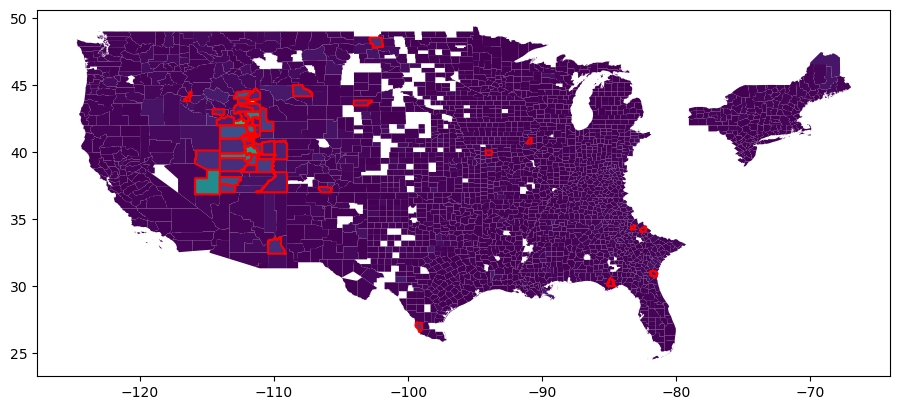

In [142]:
plot_suprising_counties(sci_dist_df, 51530, 'geo_density_resid', n_counties=50)

It turns out, Buena Vista City Virginia is home to Southern Virginia University, a [Mormon University](https://archive.sltrib.com/article.php?id=9363275&itype=NGPSID)!

Now, let's filter the data to see if we get more interesting results after filtering on each population:

In [144]:
# Filter on each pop
dist = np.percentile(sci_dist_df['geo_dist'], 50)
geofar_df = sci_dist_df[sci_dist_df['geo_dist']>dist]
sci_dist_df['avg_pop'] = (sci_dist_df['user_pop']+sci_dist_df['fr_pop'])/2
pop = np.percentile(sci_dist_df['avg_pop'], 50)
dist = np.percentile(sci_dist_df['geo_dist'], 50)
filtpop_df = sci_dist_df[sci_dist_df['user_pop']>pop]
filtpop_df = filtpop_df[filtpop_df['fr_pop']>pop]
filtpopdist_df = filtpop_df[filtpop_df['geo_dist']>dist]

filtpopdist_df.sort_values('geo_density_resid', ascending=False)[['user_loc','user_county','user_state','fr_county','fr_state']].head(10)

,user_loc,user_county,user_state,fr_county,fr_state
55075,28113,Pike,MISSISSIPPI,Marinette,WISCONSIN
28113,55075,Marinette,WISCONSIN,Pike,MISSISSIPPI
13039,53035,Kitsap,WASHINGTON,Camden,GEORGIA
53035,13039,Camden,GEORGIA,Kitsap,WASHINGTON
48027,13179,Liberty,GEORGIA,Bell,TEXAS
13179,48027,Bell,TEXAS,Liberty,GEORGIA
35009,12091,Okaloosa,FLORIDA,Curry,NEW MEXICO
12091,35009,Curry,NEW MEXICO,Okaloosa,FLORIDA
48099,13179,Liberty,GEORGIA,Coryell,TEXAS
13179,48099,Coryell,TEXAS,Liberty,GEORGIA


One interesting pairing: Camden county Georgia and Kitsap Washington. 

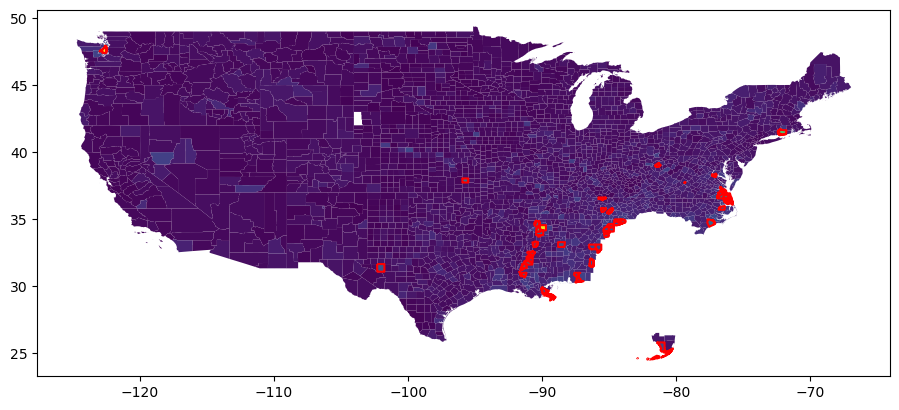

In [146]:
plot_suprising_counties(sci_dist_df, 13039, 'geo_density_resid', n_counties=50)

Turns out they both have a naval base!